
PF–MLE Results:
d=0.010, rho=0.500, sigma_eta=0.200, sigma_nu=0.200, sigma_y=0.300, sigma_pi=0.300
LogLik=-38.334

UKF–MLE Results:
d=0.047, rho=0.436, sigma_eta=0.114, sigma_nu=0.000, sigma_y=0.249, sigma_pi=0.312
LogLik=-26.415


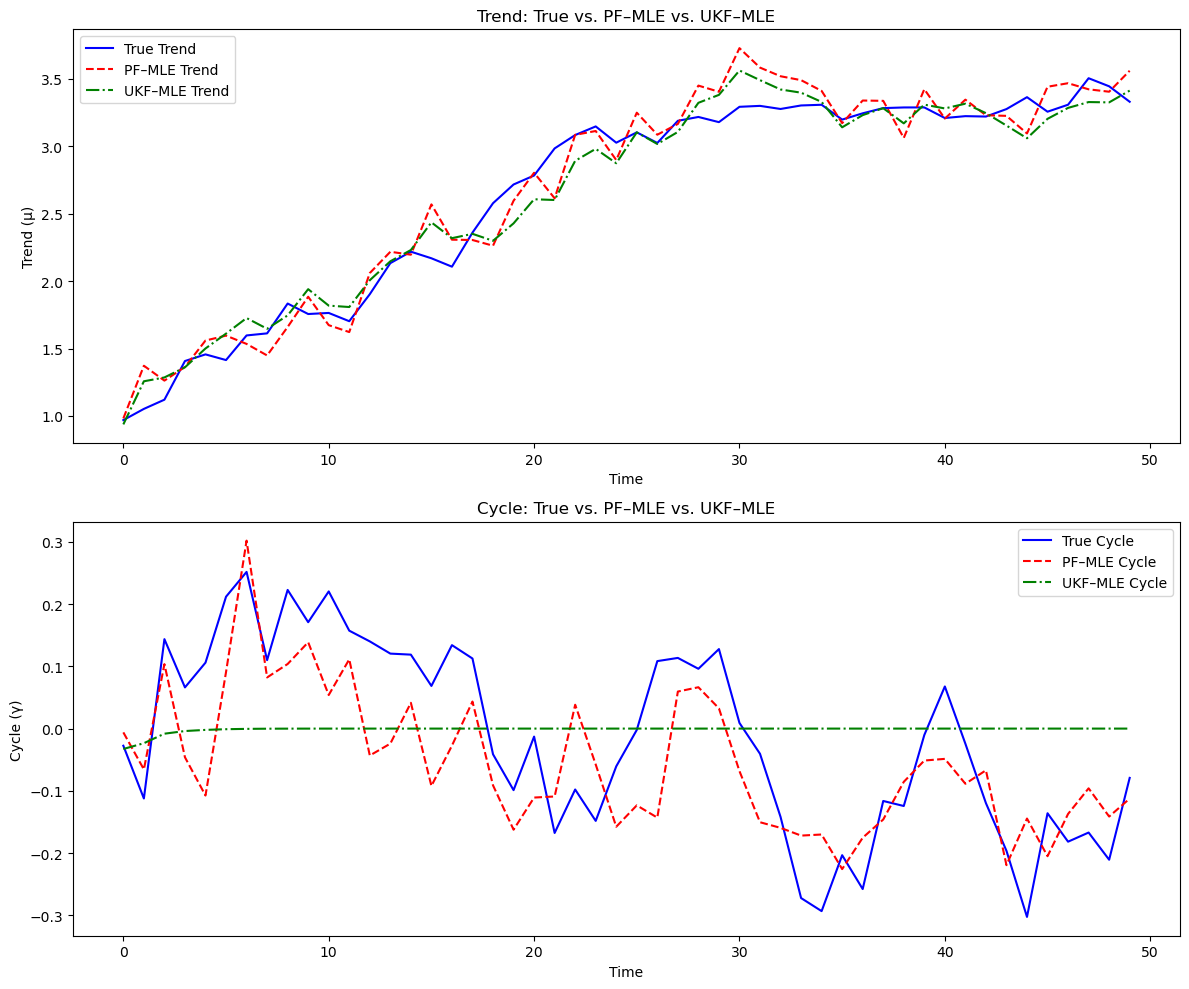

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import multivariate_normal
from scipy.stats import multivariate_normal as mvn
from scipy.optimize import minimize

try:
    from filterpy.kalman import UnscentedKalmanFilter, MerweScaledSigmaPoints
except ImportError:
    raise ImportError("Please install filterpy (pip install filterpy) to run the UKF portion.")

# =============================================================================
# 1. Global Phillips Curve Parameters (Fixed)
# =============================================================================
phi0 = 0.0   # intercept
phi1 = 0.5   # linear sensitivity
phi2 = 2.0   # extra sensitivity when gap >= 0

# =============================================================================
# 2. State Transition and Measurement Functions (with parameters)
# =============================================================================
def fx(x, params):
    """
    State transition function (without noise).
    x: [mu, gamma]
    params: [d, rho, sigma_eta, sigma_nu, sigma_y, sigma_pi]
    """
    d, rho, _, _, _, _ = params
    mu, gamma = x
    mu_new = mu + d
    gamma_new = rho * gamma
    return np.array([mu_new, gamma_new])

def hx(x):
    """
    Measurement function.
    x: [mu, gamma]
    Returns: [GDP, inflation]
       GDP = mu + gamma
       inflation = phi0 + phi1 * gamma + phi2 * max(gamma, 0)
    """
    mu, gamma = x
    GDP = mu + gamma
    inflation = phi0 + phi1 * gamma + phi2 * max(gamma, 0)
    return np.array([GDP, inflation])

# =============================================================================
# 3. Data Simulation
# =============================================================================
def simulate_data(params, T=50, x0=np.array([1.0, 0.0])):
    """
    Simulate states and observations.
    params: [d, rho, sigma_eta, sigma_nu, sigma_y, sigma_pi]
    """
    d, rho, sigma_eta, sigma_nu, sigma_y, sigma_pi = params
    Q = np.diag([sigma_eta**2, sigma_nu**2])   # process noise covariance
    R = np.diag([sigma_y**2,   sigma_pi**2])     # measurement noise covariance

    states = []
    observations = []
    x_true = x0.copy()
    for t in range(T):
        # Propagate state (deterministic step then add noise)
        x_true = fx(x_true, params) + multivariate_normal(mean=np.zeros(2), cov=Q)
        states.append(x_true.copy())
        # Generate observation with measurement noise
        z = hx(x_true) + multivariate_normal(mean=np.zeros(2), cov=R)
        observations.append(z.copy())
    return np.array(states), np.array(observations)

# =============================================================================
# 4. Utility: Systematic Resampling
# =============================================================================
def systematic_resample(weights):
    """Systematic resampling."""
    N = len(weights)
    positions = (np.arange(N) + np.random.rand()) / N
    indexes = np.zeros(N, dtype=int)
    cumulative_sum = np.cumsum(weights)
    i, j = 0, 0
    while i < N:
        if positions[i] < cumulative_sum[j]:
            indexes[i] = j
            i += 1
        else:
            j += 1
    return indexes

# =============================================================================
# 5. Particle Filter Functions
# =============================================================================
def particle_filter_filtering(observations, params, N=1000):
    """
    Runs a bootstrap particle filter and returns the particles and weights.
    observations: array of shape (T,2)
    params: [d, rho, sigma_eta, sigma_nu, sigma_y, sigma_pi]
    """
    T = len(observations)
    dim = 2
    d, rho, sigma_eta, sigma_nu, sigma_y, sigma_pi = params
    Q = np.diag([sigma_eta**2, sigma_nu**2])
    R = np.diag([sigma_y**2, sigma_pi**2])
    
    particles = np.zeros((T, N, dim))
    weights = np.zeros((T, N))
    
    # Initialize particles: assume initial state ~ N([1,0], 0.1*I)
    init_mean = np.array([1.0, 0.0])
    init_cov = np.eye(dim)*0.1
    particles[0] = multivariate_normal(mean=init_mean, cov=init_cov, size=N)
    weights[0] = np.ones(N) / N
    
    for t in range(1, T):
        for i in range(N):
            # Propagate each particle using the state function and add process noise
            particles[t, i] = fx(particles[t-1, i], params) + \
                              multivariate_normal(mean=np.zeros(dim), cov=Q)
        # Compute importance weights using the measurement density
        for i in range(N):
            z_pred = hx(particles[t, i])
            weights[t, i] = mvn.pdf(observations[t], mean=z_pred, cov=R)
        # Avoid round-off issues and normalize
        weights[t] += 1e-300
        weights[t] /= np.sum(weights[t])
        
        # Resample if effective sample size (ESS) is below threshold
        ess = 1.0 / np.sum(weights[t]**2)
        if ess < N/2:
            idx = systematic_resample(weights[t])
            particles[t] = particles[t, idx]
            weights[t] = np.ones(N) / N
            
    return particles, weights

def particle_filter_loglik(params, observations, N=500):
    """
    Approximates the log-likelihood using a bootstrap particle filter.
    params: [d, rho, sigma_eta, sigma_nu, sigma_y, sigma_pi]
    observations: array of shape (T,2)
    """
    T = len(observations)
    d, rho, sigma_eta, sigma_nu, sigma_y, sigma_pi = params
    Q = np.diag([sigma_eta**2, sigma_nu**2])
    R = np.diag([sigma_y**2, sigma_pi**2])
    
    particles = np.zeros((T, N, 2))
    weights = np.zeros((T, N))
    
    init_mean = np.array([1.0, 0.0])
    init_cov = np.eye(2)*0.1
    particles[0] = multivariate_normal(mean=init_mean, cov=init_cov, size=N)
    weights[0] = np.ones(N) / N
    
    loglik = 0.0
    for t in range(1, T):
        for i in range(N):
            x_prev = particles[t-1, i]
            x_det = fx(x_prev, params)
            particles[t, i] = x_det + multivariate_normal(mean=np.zeros(2), cov=Q)
        w = np.zeros(N)
        for i in range(N):
            z_pred = hx(particles[t, i])
            w[i] = mvn.pdf(observations[t], mean=z_pred, cov=R)
        w_sum = np.sum(w)
        avg_w = w_sum / N
        loglik += np.log(avg_w + 1e-300)
        w += 1e-300
        w /= (w_sum + 1e-300)
        weights[t] = w
        ess = 1.0 / np.sum(w**2)
        if ess < N/2:
            idx = systematic_resample(w)
            particles[t] = particles[t, idx]
            weights[t] = np.ones(N) / N
    return loglik

def neg_loglik_pf(theta, observations):
    """
    Negative log-likelihood for the PF-based estimator.
    theta: parameter vector [d, rho, sigma_eta, sigma_nu, sigma_y, sigma_pi]
    """
    # Enforce basic bounds on parameters
    if theta[2] <= 1e-5 or theta[3] <= 1e-5 or theta[4] <= 1e-5 or theta[5] <= 1e-5:
        return 1e10
    if theta[1] < 0.0 or theta[1] > 1.0:
        return 1e10
    ll = particle_filter_loglik(theta, observations, N=500)
    return -ll

# =============================================================================
# 6. UKF Functions and Log-Likelihood
# =============================================================================
def fx_ukf(x, dt, params):
    """UKF state transition function. dt is ignored (assumed 1)."""
    return fx(x, params)

def hx_ukf(x, params):
    """UKF measurement function."""
    return hx(x)

def ukf_loglik(params, observations):
    """
    Computes the log-likelihood from an Unscented Kalman Filter using the innovation form.
    params: [d, rho, sigma_eta, sigma_nu, sigma_y, sigma_pi]
    observations: array of shape (T,2)
    """
    T = len(observations)
    d, rho, sigma_eta, sigma_nu, sigma_y, sigma_pi = params
    Q = np.diag([sigma_eta**2, sigma_nu**2])
    R = np.diag([sigma_y**2, sigma_pi**2])
    
    def f_ukf(x, dt):
        return fx_ukf(x, dt, params)
    def h_ukf_func(x):
        return hx_ukf(x, params)
    
    points = MerweScaledSigmaPoints(n=2, alpha=0.1, beta=2.0, kappa=1.0)
    ukf = UnscentedKalmanFilter(dim_x=2, dim_z=2, fx=f_ukf, hx=h_ukf_func, dt=1.0, points=points)
    ukf.x = np.array([1.0, 0.0])
    ukf.P = np.eye(2)*0.1
    ukf.Q = Q
    ukf.R = R
    
    loglik = 0.0
    for t in range(T):
        ukf.predict()
        ukf.update(observations[t])
        innov = ukf.y    # innovation (residual)
        S = ukf.S        # innovation covariance
        try:
            sign, logdetS = np.linalg.slogdet(S)
            if sign <= 0:
                return -1e10
            dim_z = 2
            term = -0.5 * (logdetS + innov.T @ np.linalg.inv(S) @ innov + dim_z * np.log(2*np.pi))
            loglik += term
        except np.linalg.LinAlgError:
            return -1e10
    return loglik

def neg_loglik_ukf(theta, observations):
    """Negative log-likelihood for the UKF-based estimator."""
    if theta[2] <= 1e-5 or theta[3] <= 1e-5 or theta[4] <= 1e-5 or theta[5] <= 1e-5:
        return 1e10
    if theta[1] < 0.0 or theta[1] > 1.0:
        return 1e10
    ll = ukf_loglik(theta, observations)
    return -ll

# =============================================================================
# 7. Main Script
# =============================================================================
if __name__ == '__main__':
    # True parameters for simulation: [d, rho, sigma_eta, sigma_nu, sigma_y, sigma_pi]
    true_params = np.array([0.02, 0.9, 0.1, 0.1, 0.2, 0.2])
    T = 50
    states_true, obs = simulate_data(true_params, T=T)
    
    # Initial guesses for MLE
    param0 = np.array([0.01, 0.5, 0.2, 0.2, 0.3, 0.3])
    bounds = [(None, None), (0.0, 1.0), (1e-5, None), (1e-5, None), (1e-5, None), (1e-5, None)]
    
    # 7.1. PF–MLE
    from functools import partial
    pf_result = minimize(partial(neg_loglik_pf, observations=obs), param0,
                         method='L-BFGS-B', bounds=bounds,
                         options={'disp': True, 'maxiter': 50})
    pf_est_params = pf_result.x
    print("\nPF–MLE Results:")
    print("d=%.3f, rho=%.3f, sigma_eta=%.3f, sigma_nu=%.3f, sigma_y=%.3f, sigma_pi=%.3f"
          % tuple(pf_est_params))
    print("LogLik=%.3f" % (-pf_result.fun))
    
    # 7.2. UKF–MLE
    ukf_result = minimize(partial(neg_loglik_ukf, observations=obs), param0,
                          method='L-BFGS-B', bounds=bounds,
                          options={'disp': True, 'maxiter': 50})
    ukf_est_params = ukf_result.x
    print("\nUKF–MLE Results:")
    print("d=%.3f, rho=%.3f, sigma_eta=%.3f, sigma_nu=%.3f, sigma_y=%.3f, sigma_pi=%.3f"
          % tuple(ukf_est_params))
    print("LogLik=%.3f" % (-ukf_result.fun))
    
    # 7.3. Final Filtered States using PF–MLE parameters
    pf_particles_est, pf_weights_est = particle_filter_filtering(obs, pf_est_params, N=1000)
    pf_est_states = np.zeros((T, 2))
    for t in range(T):
        pf_est_states[t] = np.average(pf_particles_est[t], axis=0, weights=pf_weights_est[t])
    
    # 7.4. Final Filtered States using UKF–MLE parameters
    def fx_ukf_est(x, dt):
        return fx(x, ukf_est_params)
    def hx_ukf_est(x):
        return hx(x)
    points = MerweScaledSigmaPoints(n=2, alpha=0.1, beta=2.0, kappa=1.0)
    ukf_est = UnscentedKalmanFilter(dim_x=2, dim_z=2, fx=fx_ukf_est, hx=hx_ukf_est,
                                    dt=1.0, points=points)
    Q_est = np.diag([ukf_est_params[2]**2, ukf_est_params[3]**2])
    R_est = np.diag([ukf_est_params[4]**2, ukf_est_params[5]**2])
    ukf_est.x = np.array([1.0, 0.0])
    ukf_est.P = np.eye(2)*0.1
    ukf_est.Q = Q_est
    ukf_est.R = R_est
    ukf_states = np.zeros((T, 2))
    for t in range(T):
        ukf_est.predict()
        ukf_est.update(obs[t])
        ukf_states[t] = ukf_est.x.copy()
    
    # =============================================================================
    # 8. Plotting the Results
    # =============================================================================
    time = np.arange(T)
    plt.figure(figsize=(12, 10))
    
    # Plot Trend (mu)
    plt.subplot(2, 1, 1)
    plt.plot(time, states_true[:, 0], 'b-', label='True Trend')
    plt.plot(time, pf_est_states[:, 0], 'r--', label='PF–MLE Trend')
    plt.plot(time, ukf_states[:, 0], 'g-.', label='UKF–MLE Trend')
    plt.xlabel('Time')
    plt.ylabel('Trend (μ)')
    plt.title('Trend: True vs. PF–MLE vs. UKF–MLE')
    plt.legend()
    
    # Plot Cycle (gamma)
    plt.subplot(2, 1, 2)
    plt.plot(time, states_true[:, 1], 'b-', label='True Cycle')
    plt.plot(time, pf_est_states[:, 1], 'r--', label='PF–MLE Cycle')
    plt.plot(time, ukf_states[:, 1], 'g-.', label='UKF–MLE Cycle')
    plt.xlabel('Time')
    plt.ylabel('Cycle (γ)')
    plt.title('Cycle: True vs. PF–MLE vs. UKF–MLE')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
